# Ground Effect

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
import math
import os
from scipy import integrate

import certain airfoils  
One should be NACA0012  
other should be a cambered airfoil

In [2]:
class Panel:
    """
    Contains information pertaining to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        else:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [3]:
def define_panels(x,y):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    N = len(x)-1
    panels = numpy.empty(N,dtype = object)
    for i in range(N):
        panels[i] = Panel(x[i],y[i],x[i+1],y[i+1])
    return panels

In [4]:
#creating class for freesream
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees to radians


In [5]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk + (y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2 + (y - (panel.ya + numpy.cos(panel.beta)*s))**2))
    
    return integrate.quad(lambda s:integrand(s), 0.0, panel.length)[0]

In [6]:
def source_matrix(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from other panels
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.cos(p_i.beta), numpy.sin(p_i.beta))
    return A

In [7]:
def vortex_matrix(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from other panels
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
    return A

In [8]:
def build_matrix(panels):
    
    N = len(panels)                                      # no. of panels
    kutta = numpy.empty((2,N+2), dtype=float)            # initializing kutta condition matrix
    At = numpy.empty((N,N+2), dtype=float)               # initializing tangential contribution matrix
    main = numpy.empty((N), dtype=float)                 # initializing source contribution on main airfoil tangential
    flap = numpy.empty((N), dtype=float)                 # initializing source contribution on main airfoil tangential
    B = numpy.empty((N,2), dtype=float)                  # initializing vortex contribution matrix
    A = numpy.empty((N+2,N+2), dtype=float)              # initializing singularity matrix
    
    An = source_matrix(panels)
    Bn = vortex_matrix(panels)
    
    for i, panel_i in enumerate(panels):
        B[i,0] = numpy.sum(Bn[i,:int(N/2)])
        B[i,1] = numpy.sum(Bn[i,int(N/2):])
    
    for i, panel_i in enumerate(panels):
        main[i] = numpy.sum(An[i,:int(N/2)])
        flap[i] = numpy.sum(An[i,int(N/2):])
    
    At[:N,:N] = Bn
    At[:,-2] = -main
    At[:,-1] = -flap
    kutta[0,:] = At[0,:] + At[int(N/2-1),:]
    kutta[1,:] = At[int(N/2),:] + At[-1,:]
    A[0:N,0:N], A[0:N,N:], A[N:,:] = An, B, kutta
    
    return A, At

In [9]:
def build_freestream_rhs(panels, freestream):
    """Builds the right hand-side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: Numpy 1d array (float)
        Freestream contribution on each panel and on the Kutta condition.
    """
    N = len(panels)
    b = numpy.empty(N+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    
    # freestream contribution on the Kutta condition on main airfoil
    b[-2] = -freestream.u_inf * (math.sin(freestream.alpha - panels[0].beta) + math.sin(freestream.alpha - panels[int(N/2-1)].beta))
    # freestream contribution on the Kutta condition on flap
    b[-1] = -freestream.u_inf * (math.sin(freestream.alpha - panels[int(N/2)].beta) + math.sin(freestream.alpha - panels[-1].beta))
    return b

In [10]:
def compute_tangential_velocity(panels, freestream, gamma, At):
    
    N = len(panels)
    strengths = numpy.append([panel.sigma for panel in panels],gamma)
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    vt = numpy.dot(At,strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [11]:
def compute_pressure_coefficient(panels,freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [13]:
def rotate(x,y,xc,yc,theta): 
    
    theta = theta * math.pi/180
    x, y = x - xc, y - yc                             # translating hinge point to origin
    x1 = x * math.cos(theta) + y * math.sin(theta)     # rotation 
    y1 = -x * math.sin(theta) + y * math.cos(theta)
    x, y = x1 + xc, y1 + yc                             # translating hinge point back to original position
    
    return x,y

# main

In [17]:
filepath = os.path.join('resources','naca0012.dat')
with open(filepath) as filename:
    x,y = numpy.loadtxt(filename,unpack=True)

alpha, h = 4, 0.3
u_inf = 1.0
xc, yc = max(x), y[numpy.where(x==max(x))]
x,y = rotate(x,y,xc,yc,alpha)
x,y = x, y+h+min(y)

In [18]:
panels_main = define_panels(x,y)
panels_image = define_panels(x,-y)
panels = numpy.concatenate((panels_main, panels_image))

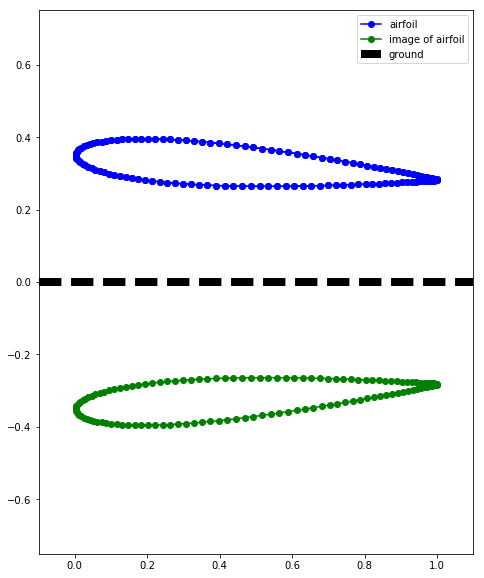

In [19]:
pyplot.figure(figsize=(10,10))
pyplot.plot([panel.xa for panel in panels_main], [panel.ya for panel in panels_main],'-bo',label='airfoil')
pyplot.plot([panel.xa for panel in panels_image],[panel.ya for panel in panels_image],'-go',label='image of airfoil')
pyplot.plot(x,y,'-bo')
pyplot.axhline(y=0, linestyle = '--',linewidth = 8, color = 'k',label = 'ground')
pyplot.legend(loc='upper right')
pyplot.axis('scaled',adjustable='box')
pyplot.xlim(-0.1,1.1)
pyplot.ylim(-0.75,0.75);

In [24]:
freestream = Freestream()
        
A, At = build_matrix(panels)
b = build_freestream_rhs(panels,freestream)
strengths = numpy.linalg.solve(A,b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]

gamma = strengths[-2:]
compute_tangential_velocity(panels,freestream,gamma,At)
compute_pressure_coefficient(panels,freestream)

lift,drag = 0.,0.
for panel in panels:
    lift -= panel.cp*panel.length*numpy.sin(panel.beta)
    drag += panel.cp*panel.length*numpy.cos(panel.beta)

In [25]:
lift,drag

(-1001.4963237868504, 47.570651602775392)

In [28]:
def get_velocity_field(panels, freestream, gamma, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    # add the contribution from each source
    vec_integral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 1, 0) - gamma/(1.5*math.pi) * vec_integral(X,Y,panel,1,0)
        v += panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 0, 1) - gamma)/(2.0*math.pi) * vec_integral(X,Y,panel,0,1)
#     u -= gamma/(1.5*math.pi) * vec_integral(X,Y,panel,1,0)
#     v -= gamma/(2.0*math.pi) * vec_integral(X,Y,panel,0,1)
    return u, v

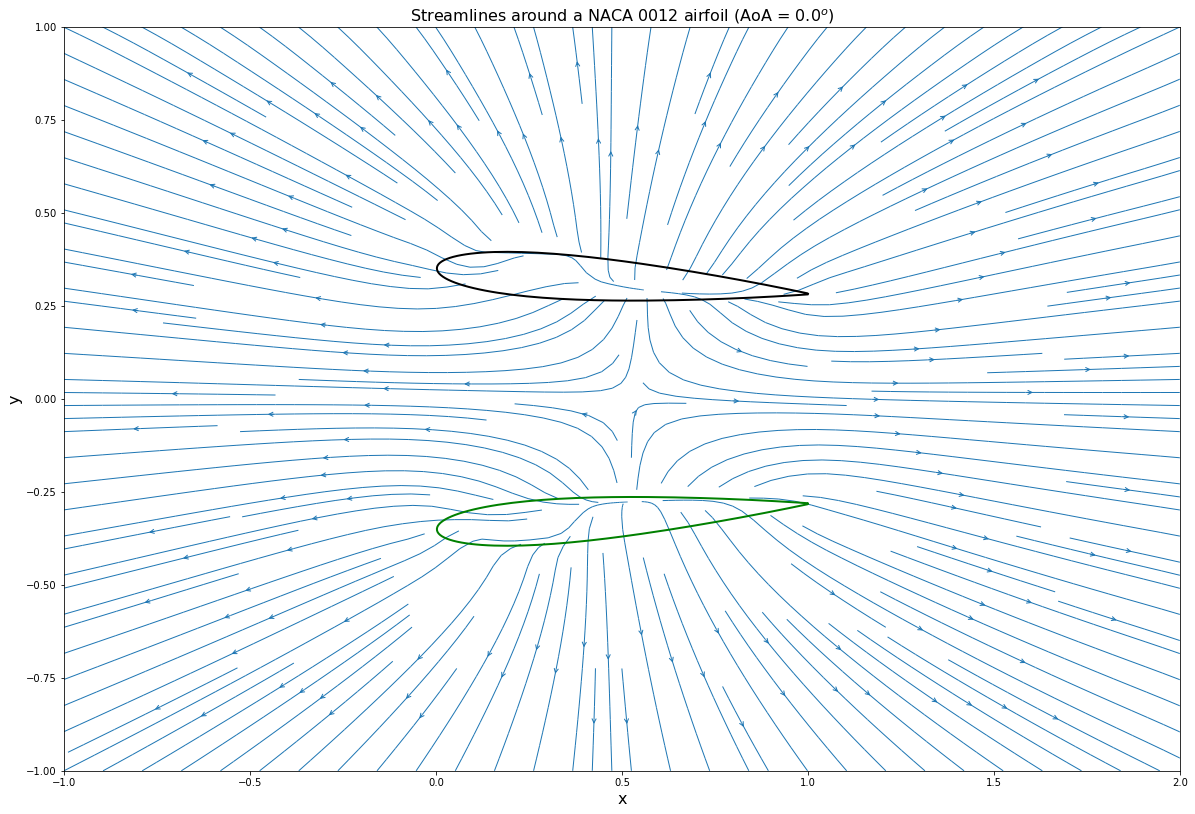

In [33]:
#defining the meshgrid
nx, ny = 30, 30  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -1.0, 1.0
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx), numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, gamma, X, Y)

#plotting the velocity field
width = 20
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.plot([panel.xc for panel in panels_main],[panel.yc for panel in panels_main],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.plot([panel.xc for panel in panels_image],[panel.yc for panel in panels_image],
            color='g', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(freestream.alpha), fontsize=16);

# Without image

In [31]:
filepath = os.path.join('resources','naca0012.dat')
with open(filepath) as filename:
    x,y = numpy.loadtxt(filename,unpack=True)

In [32]:
panels= define_panels(x,y)
# panels_image = define_panels(x,-y)
# panels = numpy.concatenate((panels_main, panels_image))

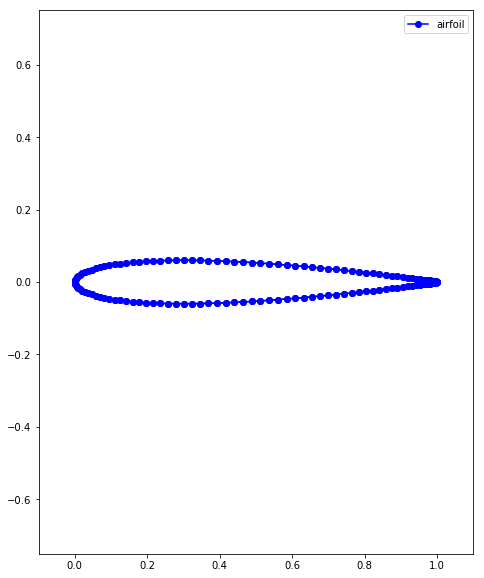

In [33]:
pyplot.figure(figsize=(10,10))
pyplot.plot([panel.xa for panel in panels], [panel.ya for panel in panels],'-bo',label='airfoil')
#pyplot.plot([panel.xa for panel in panels_image],[panel.ya for panel in panels_image],'-go',label='image of airfoil')
pyplot.plot(x,y,'-bo')
# pyplot.axhline(y=0, linestyle = '--',linewidth = 8, color = 'k',label = 'ground')
pyplot.legend(loc='upper right')
pyplot.axis('scaled',adjustable='box')
pyplot.xlim(-0.1,1.1)
pyplot.ylim(-0.75,0.75);

In [34]:
freestream = Freestream(u_inf=1.0,alpha=90)

A, At = build_matrix(panels)
b = build_freestream_rhs(panels,freestream)

gamma = numpy.linalg.solve(A,b)

for i, panel in enumerate(panels):
    panel.sigma = gamma[i]

compute_tangential_velocity(panels, freestream)
compute_pressure_coefficient(panels, freestream)

lift,drag = 0.,0.
for panel in panels:
    lift -= panel.cp*panel.length*numpy.sin(panel.beta)
    drag += panel.cp*panel.length*numpy.cos(panel.beta)

print('lift coefficient: CL = {}'.format(lift)

SyntaxError: unexpected EOF while parsing (<ipython-input-34-26980cc17125>, line 19)

In [35]:
sum([panel.sigma for panel in panels])

0.0

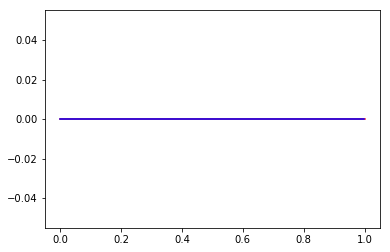

In [36]:
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],[panel.cp for panel in panels if panel.loc == 'upper'],'-r')
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],[panel.cp for panel in panels if panel.loc == 'lower'],'-b')


In [37]:
def get_velocity_field(panels, freestream, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1, 0)
        v += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0, 1)
    
    return u, v

In [58]:
# define a mesh grid
nx, ny = 20, 20  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

C:\Users\adeen\Anaconda3\lib\site-packages\numpy\ma\core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


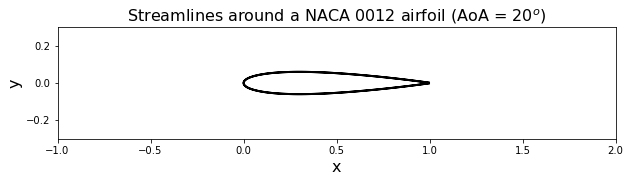

In [59]:
# plot the velocity field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha), fontsize=16);

In [62]:
sum([panel.sigma for panel in panels])

289.4076279705713